In [1]:
from collections import defaultdict
import csv
from sklearn import linear_model
from sklearn.decomposition import PCA
import scipy
import scipy.optimize
import random
import numpy as np

import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable

import pandas as pd 
from IPython.display import display

In [2]:
def readCSV(path):
  f = open(path, 'rt')
  f.readline()
  for l in f:
    yield l.strip().split(',')
    
def calc_model_stats(pred,label):
    
    TP,FP,TN,FN = calc_metrics(pred,label)

    # print("Stats")
    # print(TP,FP,TN,FN)

    # print("Predict N: {} ({}%)".format(TN+FN,(TN+FN)/(TP+TN+FP+FN)))
    # print("Predict P: {} ({}%)".format(TP+FP,(TP+FP)/(TP+TN+FP+FN)))

    accuracy, TPR, TNR, BER = calc_error_rates(TP, FP, TN, FN)

    print("Accuracy: {}".format(accuracy))
    # print("TPR: {}".format(TPR))
    # print("TNR: {}".format(TNR))
    # print("BER: {}".format(BER))
    
    return
 
def calc_metrics(predictions, labels):
    # Calculate True positives, false positives, etc.

    TP_ = numpy.logical_and(predictions, labels)
    FP_ = numpy.logical_and(predictions, numpy.logical_not(labels))
    TN_ = numpy.logical_and(numpy.logical_not(predictions), numpy.logical_not(labels))
    FN_ = numpy.logical_and(numpy.logical_not(predictions), labels)

    TP=sum(TP_)
    FP=sum(FP_)
    TN=sum(TN_)
    FN=sum(FN_)
    
    return TP,FP,TN,FN

def calc_error_rates(TP, FP, TN, FN):
    # Calculate accuracy, TPR, TNR and BER
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    TPR = TP/(TP+FN)
    TNR = TN/(TN+FP)
    BER = 1.0 - (TPR+TNR)/2
    
    return accuracy, TPR, TNR, BER


### Split Training Dataset into Train and Validation Datasets

In [3]:
dataset = []

for user,book,rating in readCSV("../datasets/cse258/assignment1/train_Interactions.csv"):
  dataset.append([user,book,rating])

random.shuffle(dataset)

X = [values[0:2] for values in dataset]
y = [int(values[-1]) for values in dataset]

N = len(dataset)
Ntrain = 190001

Xtrain = X[:Ntrain]
Xvalid = X[Ntrain:]

ytrain = y[:Ntrain]
yvalid = y[Ntrain:]

print(N, len(ytrain),len(yvalid))

200000 190001 9999


### Adopt code from Workbook 4

In [10]:
ratingsPerUser = defaultdict(list)
ratingsPerItem = defaultdict(list)

for user,book,rating in dataset:
    ratingsPerUser[user].append(rating)
    ratingsPerItem[book].append(rating)

N = len(Xtrain)
nUsers = len(ratingsPerUser)
nItems = len(ratingsPerItem)
users = list(ratingsPerUser.keys())
items = list(ratingsPerItem.keys())

print (nUsers, nItems)
print (users[:3])
print (items[:3])

11357 7170
['u88723822', 'u26592179', 'u61403643']
['b46609859', 'b32330627', 'b60684530']


In [12]:
ratingMean = sum([y for y in ytrain])/len(ytrain)

print("Mean of ratings in training set: {}".format(ratingMean))

Mean of ratings in training set: 3.8970215946231863


In [6]:
alpha = ratingMean

userBiases = defaultdict(float)
itemBiases = defaultdict(float)

def MSE(predictions, labels):
    differences = [(x-y)**2 for x,y in zip(predictions,labels)]
    return sum(differences) / len(differences)

def prediction(user, item):
    return alpha + userBiases[user] + itemBiases[item]

def unpack(theta):
    global alpha
    global userBiases
    global itemBiases
    alpha = theta[0]
    userBiases = dict(zip(users, theta[1:nUsers+1]))
    itemBiases = dict(zip(items, theta[1+nUsers:]))
    
def cost(theta, labels, lamb):
    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xtrain]
    cost = MSE(predictions, labels)
    print("MSE = " + str(cost))
    for u in userBiases:
        cost += lamb*userBiases[u]**2
    for i in itemBiases:
        cost += lamb*itemBiases[i]**2
    return cost

def derivative(theta, labels, lamb):
    unpack(theta)
    N = len(dataset)
    dalpha = 0
    dUserBiases = defaultdict(float)
    dItemBiases = defaultdict(float)
    for value in zip(Xtrain,ytrain):
        x,rating = value
        user = x[0]
        book = x[1]
        pred = prediction(user,book)
        diff = pred - rating
        dalpha += 2/N*diff
        dUserBiases[user] += 2/N*diff
        dItemBiases[book] += 2/N*diff
    for u in userBiases:
        dUserBiases[u] += 2*lamb*userBiases[u]
    for i in itemBiases:
        dItemBiases[i] += 2*lamb*itemBiases[i]
    dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
    return numpy.array(dtheta)

In [7]:
lamb_values = [1e-5,1.3e-5,1.5e-5,1.7e-5,1.8e-5,2e-5,5e-5]
MSE_valid =[]
best_theta = []
best_MSE = 0

for lamb in lamb_values:
    print("Lambda = {}".format(lamb))
  
    theta_init = [alpha] + [0.0]*(nUsers+nItems)
    unpack(theta_init)
    
    def cost(theta, labels, lamb):
        unpack(theta)
        predictions = [prediction(user, book) for user,book in Xtrain]
        cost = MSE(predictions, labels)
        print("MSE = " + str(cost))
        for u in userBiases:
            cost += lamb*userBiases[u]**2
        for i in itemBiases:
            cost += lamb*itemBiases[i]**2
        return cost

    def derivative(theta, labels, lamb):
        unpack(theta)
        N = len(dataset)
        dalpha = 0
        dUserBiases = defaultdict(float)
        dItemBiases = defaultdict(float)
        for value in zip(Xtrain,ytrain):
            x,rating = value
            user = x[0]
            book = x[1]
            pred = prediction(user,book)
            diff = pred - rating
            dalpha += 2/N*diff
            dUserBiases[user] += 2/N*diff
            dItemBiases[book] += 2/N*diff
        for u in userBiases:
            dUserBiases[u] += 2*lamb*userBiases[u]
        for i in itemBiases:
            dItemBiases[i] += 2*lamb*itemBiases[i]
        dtheta = [dalpha] + [dUserBiases[u] for u in users] + [dItemBiases[i] for i in items]
        return numpy.array(dtheta)
    
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(cost, theta_init, derivative, args = (ytrain, lamb))

    unpack(theta)
    predictions = [prediction(user, book) for user,book in Xvalid]
    cost = MSE(predictions, yvalid)
    
    if best_MSE is 0:
        best_MSE = cost
        best_theta = theta
        print("Save best theta...")
    else:
        if cost < best_MSE:
            best_MSE = cost
            best_theta = theta
            print("Save best theta...")
    
    MSE_valid.append(cost)
    print(cost)

Lambda = 1e-05
MSE = 1.473873856464982
MSE = 1.456431368523354
MSE = 1.3926990442309493
MSE = 7.992699748763671
MSE = 1.369015386525905
MSE = 1.2039672102034578
MSE = 1.201903208089255
MSE = 1.1938184067777753
MSE = 1.1642185158566818
MSE = 1.0444310777472559
MSE = 0.9961973927697352
MSE = 0.9570780562063416
MSE = 0.9424563174422734
MSE = 0.9288203623178237
MSE = 0.9226515027555446
MSE = 0.9188661478677207
MSE = 0.9181155350634062
MSE = 0.9168705154643094
MSE = 0.9170858556162015
MSE = 0.9157322652244629
MSE = 0.9149927307736362
MSE = 0.9142339137164336
MSE = 0.9141373205699372
MSE = 0.9132090084612581
MSE = 0.9797877181377072
MSE = 0.912983782825024
MSE = 0.9128937238404544
MSE = 0.9129145065234482
MSE = 0.9128795012236577
MSE = 0.9127529835819246
MSE = 0.913431250117685
MSE = 0.9128888237328417
MSE = 0.9128972885782255
MSE = 0.9128438048084605
MSE = 0.9127817050062647
MSE = 0.9128158900139834
MSE = 0.9126876402347415
MSE = 0.9128705733836319
MSE = 0.9129293007563997
MSE = 0.912905033

MSE = 0.9204773987964511
MSE = 0.9205008896861069
MSE = 0.9205641897659114
MSE = 0.9205021149886699
MSE = 0.920526938844379
MSE = 0.9205359138749829
MSE = 0.9205349594077047
MSE = 0.9205337180239839
MSE = 0.920533022976005
MSE = 0.9205380861846606
MSE = 0.9205590367903724
MSE = 0.9206010820906585
MSE = 0.9205978315337793
MSE = 0.9205898525519265
MSE = 0.920637792522961
MSE = 0.9206302504042437
MSE = 0.9206231300225696
MSE = 0.9206194989551776
MSE = 0.9211533454981179
MSE = 0.9206147349746115
MSE = 0.9206103173405396
MSE = 0.9206328784657091
MSE = 0.9205502182739058
MSE = 0.9205881626679796
MSE = 0.9205948835834266
MSE = 0.9205849873875404
MSE = 0.9208202587247981
MSE = 0.9205768682622121
MSE = 0.9205516158512381
MSE = 0.9205227000333837
MSE = 0.920482813803834
MSE = 0.9204443061738207
MSE = 0.9203738860768645
MSE = 0.9204156913896236
MSE = 0.9204257320344986
MSE = 0.9204319066346137
MSE = 0.9204264851928531
MSE = 0.9204258368546867
MSE = 0.9204257468784579
MSE = 0.9204257341417151
MSE 

MSE = 0.9249552569011027
MSE = 0.9249101714877459
MSE = 0.9249085066484912
MSE = 0.9249084444275144
MSE = 0.924908442101058
MSE = 0.9249084420140499
MSE = 0.9249084420108274
MSE = 0.9249084420106874
MSE = 0.9249084420106825
MSE = 0.924908442010685
MSE = 0.9249084420106826
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.9249084420106828
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.9249084420106826
MSE = 0.9249084420106825
MSE = 0.9249084420106825
MSE = 0.924908542871265
MSE = 0.9249086594490874
MSE = 0.9249091298540754
MSE = 0.9249110769735128
MSE = 0.9249390826868168
MSE = 0.9249622153199516
MSE = 0.9249732867920089
MSE = 0.9249745067977744
MSE = 0.9249744290110493
MSE = 0.9249749609816713
MSE = 0.9249780101582573
MSE = 0.9249891772413189
MSE = 0.9250185087410511
MSE = 0.9250786223689966
MSE = 0.925161568799013
MSE = 0.9250974876908933
MSE = 0.9252042137902682
MSE = 0.9251154976401953
MSE = 0.9251955471478489
MSE = 0.9251332075932325
MSE = 0.9251928380255553
MSE 

MSE = 0.9867104509815025
MSE = 0.9867094291989861
MSE = 0.9867081093267677
MSE = 0.9867104391852625
MSE = 0.9867241918666048
MSE = 0.9867605720141834
MSE = 0.9868166188258535
MSE = 0.9867749470878149
MSE = 0.9868569702638745
MSE = 0.9867953077462814
MSE = 0.9868661281270799
MSE = 0.9868102664157358
MSE = 0.9868656551361018
MSE = 0.9868202978994945
MSE = 0.986864887275064
MSE = 0.9868272802456884
MSE = 0.9868216530546479
MSE = 0.9868205712934234
MSE = 0.9868203534822335
MSE = 0.9868203092176432
MSE = 0.9868203002051508
MSE = 0.986820298369123
MSE = 0.9868202979954149
MSE = 0.9868202979190244
MSE = 0.986820297969391
MSE = 0.986820297929405
MSE = 0.9868202979210295
MSE = 0.9868202979190244
1.105219727805016


In [8]:
for lamb, MSE in zip(lamb_values ,MSE_valid):
    print ("Lamb-{} gives Validation MSE of {}".format(lamb, MSE))

Lamb-1e-05 gives Validation MSE of 1.0741282593688577
Lamb-1.3e-05 gives Validation MSE of 1.0735889944967134
Lamb-1.5e-05 gives Validation MSE of 1.0734200113625347
Lamb-1.7e-05 gives Validation MSE of 1.0737866337278643
Lamb-1.8e-05 gives Validation MSE of 1.074256054597343
Lamb-2e-05 gives Validation MSE of 1.076102050248465
Lamb-5e-05 gives Validation MSE of 1.105219727805016


In [16]:
print(len(best_theta))

print(best_theta[0])
print(best_theta[1:nUsers+1])
print(best_theta[nUsers+1:])

18528
11357
3.8115271045716583
[-0.55554225 -0.62195259 -3.27765648 ...  0.32498864 -0.19803966
 -0.00600419]
[ 0.36158633  0.64962104 -0.6115337  ...  0.02200522  0.17283829
 -0.22501942]


## Assignment 1 Kaggle Submission - Lambda=1.2e-5,  MSE=1.143, User_Name='Luke Liem'

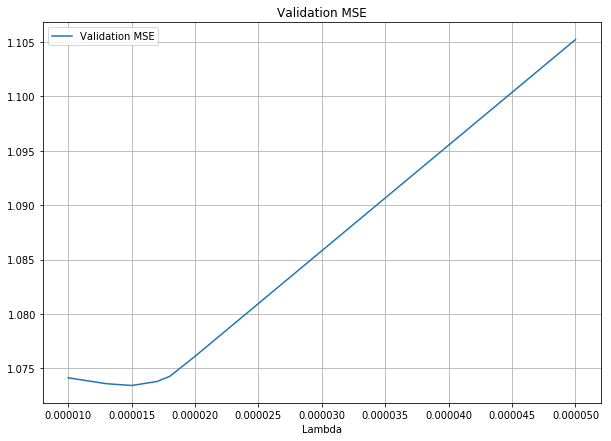

In [18]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(10,7))

plt.xlabel('Lambda')
plt.title('Validation MSE')
plt.grid(True)

plt.plot(lamb_values, MSE_valid, label='Validation MSE')

plt.legend()
plt.show()

In [24]:
best_theta

array([ 3.81233938,  0.3113362 ,  0.46095858, ..., -0.3010043 ,
       -0.01805242, -0.26187858])

In [26]:
### Rating baseline: compute averages for each user, or return 
### the global average if we've never seen the user before

predictions = open("assignment1/predictions_Rating.txt", 'w')
unpack(best_theta)

for l in open("assignment1/pairs_Rating.txt"):
  # write header  
  if l.startswith("userID"):
    predictions.write(l)
    continue
    
  # write user-item-rating
  u,b = l.strip().split('-')
  predictions.write(u + '-' + b + ',' + str(prediction(u,b)) + '\n')

predictions.close()

## PyTorch Model

### Try to replicate Assignment Result for Bias-Only Model

In [4]:
def lookup_index(list, id):
    return list.index(id)

def id_to_index_reformat(X):
    x_new = []
    
    for x in X:
        uid = x[0]
        bid = x[1]
        # print(uid,bid)
        
        uidx = lookup_index(user_ids,uid)
        bidx = lookup_index(book_ids,bid)
        # print(uidx,bidx)
        
        x_new.append([uidx,bidx])
    return x_new
    

def l2_regularize(array):
    loss = torch.sum(array ** 2.0)
    return loss

class MF(nn.Module):
    # itr = 0
    
    def __init__(self, n_user, n_item, k=1, c_vector=1.0, c_bias=1.0, writer=None, mean=0):
        super(MF, self).__init__()
        self.writer = writer
        self.k = k
        self.n_user = n_user
        self.n_item = n_item
        self.c_bias = c_bias
        self.c_vector = c_vector
        
        # gammas (users and items)
        # self.user = nn.Embedding(n_user, k)
        # self.item = nn.Embedding(n_item, k)
        
        # alpha and betas (users and items)
        self.bias_user = nn.Embedding(n_user, 1)
        self.bias_item = nn.Embedding(n_item, 1)
        self.bias = nn.Parameter(torch.ones(1))
        
        # Initialize
        self.bias.data.fill_(mean)
        self.bias_user.weight.data.fill_(0)
        self.bias_item.weight.data.fill_(0)
    
    def forward(self, train_x):
        user_id = train_x[:, 0]
        item_id = train_x[:, 1]
        # vector_user = self.user(user_id)
        # vector_item = self.item(item_id)
        
        # Pull out biases
        bias_user = self.bias_user(user_id).squeeze()
        bias_item = self.bias_item(item_id).squeeze()
        biases = (self.bias + bias_user + bias_item)
        
        # ui_interaction = torch.sum(vector_user * vector_item, dim=1)
        
        # Add bias prediction to the interaction prediction
        # prediction = ui_interaction + biases
        
        prediction = biases
        return prediction
    
    def loss(self, prediction, target):
        loss_mse = F.mse_loss(prediction, target.squeeze())
        
        # BUG - PyTorch optimizer already takes care of regularization!!!
        
        # prior_bias_user =  l2_regularize(self.bias_user.weight) * self.c_bias
        # prior_bias_item = l2_regularize(self.bias_item.weight) * self.c_bias
        # prior_user =  l2_regularize(self.user.weight) * self.c_vector
        # prior_item = l2_regularize(self.item.weight) * self.c_vector
        # total = loss_mse + prior_user + prior_item + prior_bias_user + prior_bias_item
        
        total = loss_mse
        
        # for name, var in locals().items():
        #    if type(var) is torch.Tensor and var.nelement() == 1 and self.writer is not None:
        #        self.writer.add_scalar(name, var, self.itr)
        
        return total

In [5]:
data = pd.read_csv("../datasets/cse258/assignment1/train_Interactions.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 3 columns):
userID    200000 non-null object
bookID    200000 non-null object
rating    200000 non-null int64
dtypes: int64(1), object(2)
memory usage: 4.6+ MB


,userID,bookID,rating
0,u79354815,b14275065,4
1,u56917948,b82152306,5
2,u97915914,b44882292,5
3,u49688858,b79927466,5
4,u08384938,b05683889,2


In [6]:
book_ids = list(data['bookID'].unique())
user_ids = list(data['userID'].unique())

print(len(book_ids), book_ids[:3])
print(len(user_ids), user_ids[:3])

print(book_ids[203])
print(lookup_index(book_ids,'b52453648'))

print(user_ids[108])
print(lookup_index(user_ids,'u67309666'))

7170 ['b14275065', 'b82152306', 'b44882292']
11357 ['u79354815', 'u56917948', 'u97915914']
b52453648
203
u67309666
108


In [7]:
train_x = id_to_index_reformat(Xtrain)
valid_x = id_to_index_reformat(Xvalid)

train_y = ytrain
valid_y = yvalid

print (Xtrain[10:15], train_x[10:15])
print (Xvalid[10:15], valid_x[10:15])


[['u76247191', 'b82374557'], ['u12510042', 'b47677202'], ['u87065149', 'b15322881'], ['u56882043', 'b21517939'], ['u50024754', 'b25719319']] [[237, 857], [477, 2686], [4246, 772], [3831, 1083], [7302, 7005]]
[['u40726318', 'b25220721'], ['u00550479', 'b32614969'], ['u75580304', 'b88667874'], ['u29859759', 'b34184750'], ['u25261335', 'b98923466']] [[8095, 3119], [10009, 6560], [1776, 169], [10098, 3385], [5708, 1503]]


In [8]:
# Basic QC

for i in range(5):
    index = random.randint(0, len(train_x))
    uid = train_x[index][0]
    bid = train_x[index][1]
    print(index, uid, bid, user_ids[uid],book_ids[bid])
    print(Xtrain[index])


38604 2766 512 u27349804 b68268306
['u27349804', 'b68268306']
8084 7891 5971 u98796150 b65760924
['u98796150', 'b65760924']
60252 5250 2065 u88978112 b13620341
['u88978112', 'b13620341']
61807 3872 2206 u82123673 b94925721
['u82123673', 'b94925721']
89854 1471 1072 u59808881 b84299066
['u59808881', 'b84299066']


In [13]:
from random import shuffle

# Hyperparameters
lr = 1e-2

# New parameter for regularizing bias
lamb = 1e-5
batch_size = 1024

n_user = len(ratingsPerUser)
n_item = len(ratingsPerItem)

cuda = torch.cuda.is_available()

model = MF(n_user, n_item, mean=ratingMean)
if cuda:
    model.cuda()
    
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=lamb, momentum=0.9)

def chunks(X, Y, size):
    """Yield successive n-sized chunks from l."""
    starts = list(range(0, len(X), size))
    shuffle(starts)
    for i in starts:
        yield (X[i:i + size], Y[i:i + size])
        
losses = []
valid_losses = []

for epoch in range(1000+1):
    
    i = 0
    for feature, target in chunks(np.array(train_x), np.array(train_y), batch_size):
        # This zeros the gradients on every parameter. 
        # This is easy to miss and hard to troubleshoot.
        optimizer.zero_grad()
        # Convert 
        feature = Variable(torch.from_numpy(feature))
        target = Variable(torch.from_numpy(target).type(torch.FloatTensor))
        
        if cuda:
            feature = feature.cuda()
            target = target.cuda()
            
        # model in training mode    
        model.train()
            
        # Compute a prediction for these features
        prediction = model.forward(feature)
        # Compute a loss given what the true target outcome was
        loss = model.loss(prediction, target)
        # break
        # Backpropagate: compute the direction / gradient every model parameter
        # defined in your __init__ should move in in order to minimize this loss
        # However, we're not actually changing these parameters, we're just storing
        # how they should change.

        loss.backward()
        # Now take a step & update the model parameters. The optimizer uses the gradient at 
        # defined on every parameter in our model and nudges it in that direction.
        optimizer.step()
        
        if i%100 == 0 and epoch%10 == 0:
            print("Epoch[{}] Iteration[{}] Training Loss: {:.3f}".format(epoch, i, loss.data))

        # Record the loss per example
        losses.append(loss.cpu().data.numpy() / len(feature))
        
        if i%100 == 0 and epoch%10 == 0:
            val_feature = torch.from_numpy(np.array(valid_x))
            val_target = torch.from_numpy(np.array(valid_y)).type(torch.FloatTensor)
            
            if cuda:
                val_feature = val_feature.cuda()
                val_target = val_target.cuda()
                
            # model in test mode    
            model.eval()

            val_pred = model.forward(val_feature)
            val_loss = model.loss(val_pred, val_target)
            print("Epoch[{}] Validation Loss: {:.3f} ".format(epoch, val_loss.data))
            
            # Record the validation loss per example
            valid_losses.append(val_loss.cpu().data.numpy()/len(val_feature))

        i += 1


Epoch[0] Iteration[0] Training Loss: 1.457
Epoch[0] Validation Loss: 1.477 
Epoch[0] Iteration[100] Training Loss: 1.318
Epoch[0] Validation Loss: 1.475 
Epoch[10] Iteration[0] Training Loss: 1.230
Epoch[10] Validation Loss: 1.435 
Epoch[10] Iteration[100] Training Loss: 1.515
Epoch[10] Validation Loss: 1.433 
Epoch[20] Iteration[0] Training Loss: 1.458
Epoch[20] Validation Loss: 1.401 
Epoch[20] Iteration[100] Training Loss: 1.395
Epoch[20] Validation Loss: 1.399 
Epoch[30] Iteration[0] Training Loss: 1.346
Epoch[30] Validation Loss: 1.372 
Epoch[30] Iteration[100] Training Loss: 1.373
Epoch[30] Validation Loss: 1.370 
Epoch[40] Iteration[0] Training Loss: 1.308
Epoch[40] Validation Loss: 1.347 
Epoch[40] Iteration[100] Training Loss: 1.299
Epoch[40] Validation Loss: 1.346 
Epoch[50] Iteration[0] Training Loss: 1.284
Epoch[50] Validation Loss: 1.325 
Epoch[50] Iteration[100] Training Loss: 1.191
Epoch[50] Validation Loss: 1.324 
Epoch[60] Iteration[0] Training Loss: 1.252
Epoch[60] Va

Epoch[510] Iteration[0] Training Loss: 0.985
Epoch[510] Validation Loss: 1.113 
Epoch[510] Iteration[100] Training Loss: 0.947
Epoch[510] Validation Loss: 1.113 
Epoch[520] Iteration[0] Training Loss: 0.971
Epoch[520] Validation Loss: 1.113 
Epoch[520] Iteration[100] Training Loss: 0.988
Epoch[520] Validation Loss: 1.113 
Epoch[530] Iteration[0] Training Loss: 1.038
Epoch[530] Validation Loss: 1.113 
Epoch[530] Iteration[100] Training Loss: 0.996
Epoch[530] Validation Loss: 1.112 
Epoch[540] Iteration[0] Training Loss: 0.942
Epoch[540] Validation Loss: 1.112 
Epoch[540] Iteration[100] Training Loss: 0.967
Epoch[540] Validation Loss: 1.112 
Epoch[550] Iteration[0] Training Loss: 0.905
Epoch[550] Validation Loss: 1.112 
Epoch[550] Iteration[100] Training Loss: 0.952
Epoch[550] Validation Loss: 1.112 
Epoch[560] Iteration[0] Training Loss: 0.923
Epoch[560] Validation Loss: 1.112 
Epoch[560] Iteration[100] Training Loss: 0.841
Epoch[560] Validation Loss: 1.111 
Epoch[570] Iteration[0] Trai

In [ ]:
model.cpu()

print(ratingMean)
print(best_theta[0])
print(model.bias)
